In [1]:
import time
import numpy as np
from PIL import Image, ImageDraw

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF

import timm

assert "0.4.5" <= timm.__version__ <= "0.4.9"  # version check

from util.misc import make_grid
import models_mae_cross

device = torch.device('cuda')

In [2]:
class measure_time(object):
    def __enter__(self):
        self.start = time.perf_counter_ns()
        return self

    def __exit__(self, typ, value, traceback):
        self.duration = (time.perf_counter_ns() - self.start) / 1e9


def load_image(img_path):
    # im_dir = './data/FSC147_384_V2/images_384_VarV2'
    # im_id = '222.jpg'

    # image = Image.open('{}/{}'.format(im_dir, im_id))
    image = Image.open(img_path)
    image.load()
    W, H = image.size

    # Resize the image size so that the height is 384
    new_H = 384
    new_W = 16 * int((W / H * 384) / 16)
    scale_factor_H = float(new_H) / H
    scale_factor_W = float(new_W) / W
    image = transforms.Resize((new_H, new_W))(image)
    Normalize = transforms.Compose([transforms.ToTensor()])
    image = Normalize(image)

    # Coordinates of the exemplar bound boxes
    # The left upper corner and the right lower corner
    bboxes = [
        [[136, 98], [173, 127]],
        [[209, 125], [242, 150]],
        [[212, 168], [258, 200]]
    ]
    boxes = list()
    rects = list()
    for bbox in bboxes:
        x1 = int(bbox[0][0] * scale_factor_W)
        y1 = int(bbox[0][1] * scale_factor_H)
        x2 = int(bbox[1][0] * scale_factor_W)
        y2 = int(bbox[1][1] * scale_factor_H)
        rects.append([y1, x1, y2, x2])
        bbox = image[:, y1:y2 + 1, x1:x2 + 1]
        bbox = transforms.Resize((64, 64))(bbox)
        boxes.append(bbox.numpy())

    boxes = np.array(boxes)
    boxes = torch.Tensor(boxes)

    return image, boxes, rects
# --- #


def draw_box_on_img(img, x1,y1, x2,y2, color="red"):
    sample_img = img.copy()
    img1 = ImageDraw.Draw(sample_img, 'RGBA')  
    img1.rectangle(((x1,y1), (x2,y2)), fill=(0, 0, 0, 125), outline = color)
    return sample_img

In [3]:
# Prepare model
model = models_mae_cross.__dict__['mae_vit_base_patch16'](norm_pix_loss='store_true')
model.to(device)
model_without_ddp = model

# Load Model
checkpoint = torch.load('./checkpoints/FSC147.pth', map_location='cpu')
model_without_ddp.load_state_dict(checkpoint['model'], strict=False)
print("Resume checkpoint %s" % './checkpoints/FSC147.pth')

model.eval()

Resume checkpoint ./checkpoints/FSC147.pth


SupervisedMAE(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (decoder_embed): Linear(in_features=768, out_features=512, bias=True)
 

In [4]:
im_dir = './data/FSC147_384_V2/images_384_VarV2/213.jpg'

In [5]:


def run_one_image(samples, boxes, pos, model):
    _, _, h, w = samples.shape

    s_cnt = 0
    for rect in pos:
        if rect[2] - rect[0] < 10 and rect[3] - rect[1] < 10:
            s_cnt += 1
    if s_cnt >= 1:
        r_densities = []
        r_images = []
        r_images.append(TF.crop(samples[0], 0, 0, int(h / 3), int(w / 3)))  # 1
        r_images.append(TF.crop(samples[0], 0, int(w / 3), int(h / 3), int(w / 3)))  # 3
        r_images.append(TF.crop(samples[0], 0, int(w * 2 / 3), int(h / 3), int(w / 3)))  # 7
        r_images.append(TF.crop(samples[0], int(h / 3), 0, int(h / 3), int(w / 3)))  # 2
        r_images.append(TF.crop(samples[0], int(h / 3), int(w / 3), int(h / 3), int(w / 3)))  # 4
        r_images.append(TF.crop(samples[0], int(h / 3), int(w * 2 / 3), int(h / 3), int(w / 3)))  # 8
        r_images.append(TF.crop(samples[0], int(h * 2 / 3), 0, int(h / 3), int(w / 3)))  # 5
        r_images.append(TF.crop(samples[0], int(h * 2 / 3), int(w / 3), int(h / 3), int(w / 3)))  # 6
        r_images.append(TF.crop(samples[0], int(h * 2 / 3), int(w * 2 / 3), int(h / 3), int(w / 3)))  # 9

        pred_cnt = 0
        with measure_time() as et:
            for r_image in r_images:
                r_image = transforms.Resize((h, w))(r_image).unsqueeze(0)
                density_map = torch.zeros([h, w])
                density_map = density_map.to(device, non_blocking=True)
                start = 0
                prev = -1
                with torch.no_grad():
                    while start + 383 < w:
                        output, = model(r_image[:, :, :, start:start + 384], boxes, 3)
                        output = output.squeeze(0)
                        b1 = nn.ZeroPad2d(padding=(start, w - prev - 1, 0, 0))
                        d1 = b1(output[:, 0:prev - start + 1])
                        b2 = nn.ZeroPad2d(padding=(prev + 1, w - start - 384, 0, 0))
                        d2 = b2(output[:, prev - start + 1:384])

                        b3 = nn.ZeroPad2d(padding=(0, w - start, 0, 0))
                        density_map_l = b3(density_map[:, 0:start])
                        density_map_m = b1(density_map[:, start:prev + 1])
                        b4 = nn.ZeroPad2d(padding=(prev + 1, 0, 0, 0))
                        density_map_r = b4(density_map[:, prev + 1:w])

                        density_map = density_map_l + density_map_r + density_map_m / 2 + d1 / 2 + d2

                        prev = start + 383
                        start = start + 128
                        if start + 383 >= w:
                            if start == w - 384 + 128:
                                break
                            else:
                                start = w - 384

                pred_cnt += torch.sum(density_map / 60).item()
                print("pred_cnt ",pred_cnt)
                r_densities += [density_map]
    else:
        density_map = torch.zeros([h, w])
        density_map = density_map.to(device, non_blocking=True)
        start = 0
        prev = -1
        with measure_time() as et:
            with torch.no_grad():
                while start + 383 < w:
                    output, = model(samples[:, :, :, start:start + 384], boxes, 3)
                    output = output.squeeze(0)
                    b1 = nn.ZeroPad2d(padding=(start, w - prev - 1, 0, 0))
                    d1 = b1(output[:, 0:prev - start + 1])
                    b2 = nn.ZeroPad2d(padding=(prev + 1, w - start - 384, 0, 0))
                    d2 = b2(output[:, prev - start + 1:384])

                    b3 = nn.ZeroPad2d(padding=(0, w - start, 0, 0))
                    density_map_l = b3(density_map[:, 0:start])
                    density_map_m = b1(density_map[:, start:prev + 1])
                    b4 = nn.ZeroPad2d(padding=(prev + 1, 0, 0, 0))
                    density_map_r = b4(density_map[:, prev + 1:w])

                    density_map = density_map_l + density_map_r + density_map_m / 2 + d1 / 2 + d2

                    prev = start + 383
                    start = start + 128
                    if start + 383 >= w:
                        if start == w - 384 + 128:
                            break
                        else:
                            start = w - 384
            pred_cnt = torch.sum(density_map / 60).item()

    e_cnt = 0
    for rect in pos:
        e_cnt += torch.sum(density_map[rect[0]:rect[2] + 1, rect[1]:rect[3] + 1] / 60).item()
    e_cnt = e_cnt / 3
    if e_cnt > 1.8:
        pred_cnt /= e_cnt

    # Visualize the prediction
    fig = samples[0]
    box_map = torch.zeros([fig.shape[1], fig.shape[2]])
    box_map = box_map.to(device, non_blocking=True)
    for rect in pos:
        for i in range(rect[2] - rect[0]):
            box_map[min(rect[0] + i, fig.shape[1] - 1), min(rect[1], fig.shape[2] - 1)] = 10
            box_map[min(rect[0] + i, fig.shape[1] - 1), min(rect[3], fig.shape[2] - 1)] = 10
        for i in range(rect[3] - rect[1]):
            box_map[min(rect[0], fig.shape[1] - 1), min(rect[1] + i, fig.shape[2] - 1)] = 10
            box_map[min(rect[2], fig.shape[1] - 1), min(rect[1] + i, fig.shape[2] - 1)] = 10
    box_map = box_map.unsqueeze(0).repeat(3, 1, 1)
    pred = density_map.unsqueeze(0).repeat(3, 1, 1) if s_cnt < 1 \
        else make_grid(r_densities, h, w).unsqueeze(0).repeat(3, 1, 1)
    fig = fig + box_map + pred / 2
    fig = torch.clamp(fig, 0, 1)
    torchvision.utils.save_image(fig, f'./Image/Visualisation.png')
    # GT map needs coordinates for all GT dots, which is hard to input and is not a must for the demo. You can provide it yourself.
    return pred_cnt, et, density_map, box_map, pred, fig

In [6]:
# Test on the new image
samples, boxes, pos = load_image(im_dir)
samples = samples.unsqueeze(0).to(device, non_blocking=True)
boxes = boxes.unsqueeze(0).to(device, non_blocking=True)

result, elapsed_time, density_map, box_map, pred, fig = run_one_image(samples, boxes, pos, model)
print(result, elapsed_time.duration)
show_image = transforms.ToPILImage()

/home/steven/anaconda3/envs/vision_311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


163.56430053710938 0.904724391


torch.Size([384, 384])


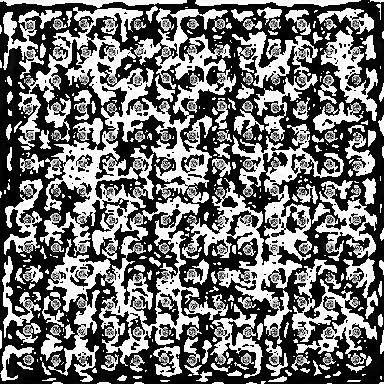

In [7]:
print(density_map.shape)
show_image(density_map)

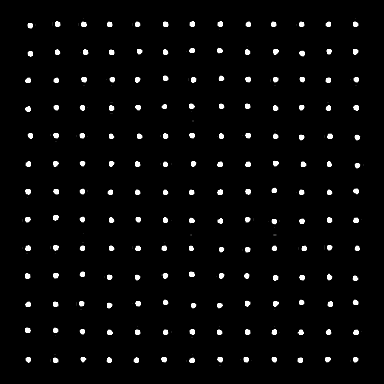

In [8]:
density_map_arr = density_map.to('cpu').numpy()
density_map_arr[density_map_arr<0] = 0
density_map_arr[density_map_arr<=0.1] = 0
density_map_arr[density_map_arr>0.5] = 1
# density_map_arr = np.repeat(density_map_arr.reshape(density_map_arr.shape[0],density_map_arr.shape[1],-1),3,axis=2)
density_map_tensor_new = torch.Tensor(density_map_arr)
show_image(density_map_tensor_new)
# Image.fromarray(density_map_arr)

### TO DO
make an object counting based on the thresholded density map.

torch.Size([3, 384, 384])


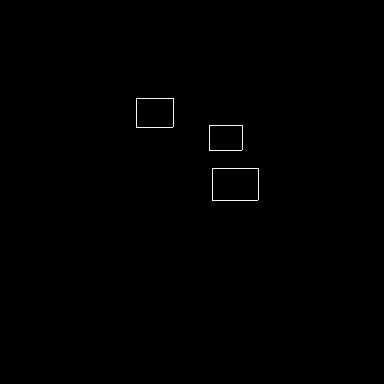

In [10]:
print(box_map.shape)
# show_image(density_map.unsqueeze(0).repeat(3, 1, 1))
show_image(box_map)

torch.Size([3, 384, 384])


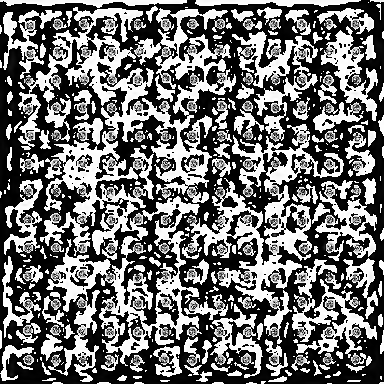

In [11]:
print(pred.shape)
# show_image(density_map.unsqueeze(0).repeat(3, 1, 1))
show_image(pred)

torch.Size([3, 384, 384])


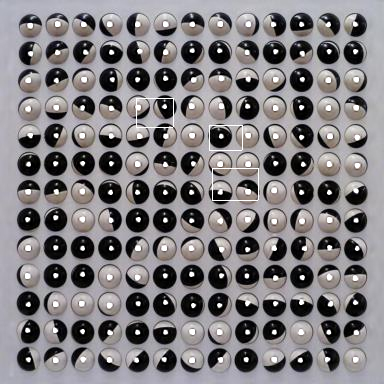

In [12]:
print(fig.shape)
# show_image(density_map.unsqueeze(0).repeat(3, 1, 1))
show_image(fig)

---